In [1]:
%matplotlib inline
from matplotlib import style

style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func

In [2]:
import numpy as np
import pandas as pd

In [3]:
from dateutil.relativedelta import relativedelta
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Use Inspector to print the column names and types
measure_columns = inspector.get_columns('measurement')
for c in measure_columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Use Inspector to print the column names and types
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute('SELECT station,count(*) FROM measurement group by station order by count(*) desc').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
engine.execute('SELECT station,count(*) FROM station group by station order by count(*) desc').fetchall()

[('USC00511918', 1),
 ('USC00513117', 1),
 ('USC00514830', 1),
 ('USC00516128', 1),
 ('USC00517948', 1),
 ('USC00518838', 1),
 ('USC00519281', 1),
 ('USC00519397', 1),
 ('USC00519523', 1)]

# Exploratory Climate Analysis

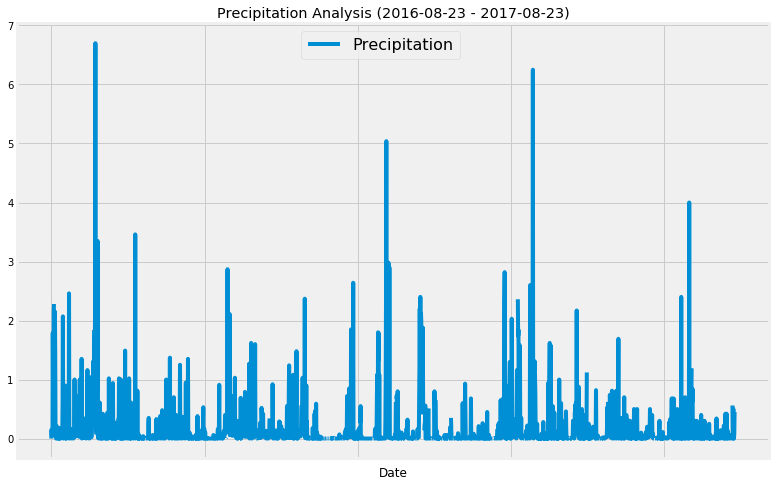

In [15]:
#get the last date 
last_date = engine.execute('SELECT max(date) FROM measurement').fetchone()
#print(last_date[0])
# Calculate the date 1 year ago from the last data point in the database
last_12mnth = (dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()
#print (last_12mnth)
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_12mnth ).\
order_by(Measurement.date).all()
#print(precipitation_data)

# Save the query results as a Pandas DataFrame 
prec_df = pd.DataFrame(precipitation_data)
precipitation_df = prec_df.rename(columns={"prcp":"Precipitation"})
precipitation_df.head()
#set the index to the date column
precipitation_df.set_index('date').head()
#Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(.6,1.001), fontsize="16")
ax.set_title(f"Precipitation Analysis ({(last_12mnth)} - {last_date[0]})")
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xlabel('Date')
plt.show()


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.id).count()
print("There are {} stations available".format(total_stations))

There are 9 stations available


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station,
                  func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).limit(5).all()
for station in active_stations:
    #print(row)
    # List the stations and the counts in descending order.
    print(f"The most active stations is {station[0]} and the total count is {station[1]}. ")

The most active stations is USC00519281 and the total count is 2772. 
The most active stations is USC00519397 and the total count is 2724. 
The most active stations is USC00513117 and the total count is 2709. 
The most active stations is USC00519523 and the total count is 2669. 
The most active stations is USC00516128 and the total count is 2612. 


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Measurement.station,
                  func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).limit(1).all()
#print(most_active_station[0][0])
active_summary = session.query(Station.id,
                  Station.name,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.station == most_active_station[0][0])
avg_temp = "{0:.2f}".format(active_summary[0][4])
print(f"Most Active Station ID: {active_summary[0][0]},\n\
Name: {most_active_station[0][0]},\n\
Location: {active_summary[0][1]} \n\nResults: \nMinimum temperature recorded:  {active_summary[0][2]}\nMaximum\
 temperture recorded : {active_summary[0][3]}\nAverage temperature recorded:  {avg_temp}")

Most Active Station ID: 7,
Name: USC00519281,
Location: WAIHEE 837.5, HI US 

Results: 
Minimum temperature recorded:  54.0
Maximum temperture recorded : 85.0
Average temperature recorded:  71.66


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observ = session.query(Measurement.tobs).\
              filter(Measurement.station==most_active_station[0][0]).\
                                filter(Measurement.date >= last_12mnth).\
                                order_by(Measurement.date.desc()).all()
temp_observ_df = pd.DataFrame(temp_observ)
temp_observ_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


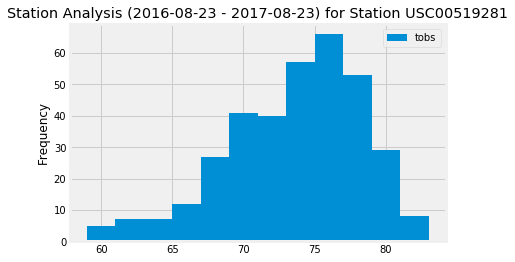

In [21]:
# plt.figure(figsize=(8,4))
plt.hist(temp_observ_df['tobs'], bins=12)
plt.ylabel("Frequency")
plt.title(f"Station Analysis ({(last_12mnth)} - {last_date[0]}) for Station { most_active_station[0][0]}")
plt.legend(["tobs"])
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#dates for previous year's data
start_date = '2011-02-28'
end_date = '2011-03-05'
calc_temp = calc_temps(start_date, end_date)#write into a dataframe
#print(calc_temp[0][0])

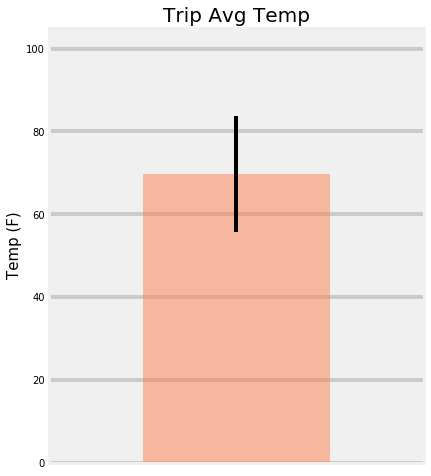

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc_temp_df = pd.DataFrame(calc_temp, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = calc_temp_df['Avg Temp']
tmin_tmax_temp = calc_temp_df.iloc[0]['Max Temp'] - calc_temp_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=tmin_tmax_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)", fontsize=15)
plt.xticks([])
plt.ylim((0,105))
plt.grid( linestyle='-', linewidth=4)
plt.show()